# MVP - Pós Graduação em Engenharia de Software (PUC Rio)
# Sprint Qualidade de Software, Segurança e Sistemas Inteligentes

O objetivo desse notebook é explorar os dados de uma base da Nasa para classificar se um objeto em órbita da terra pode vir a causar uma catástrofe global.

Colunas do dataset:

- id: identificador único do asteróide
- name: nome dado pela Nasa
- est_diameter_min: Diâmetro mínimo estimado em km
- est_diameter_max: Diâmetro máximo estimado em km
- relative_velocity: Velocidade Relativa da Terra, em km/h
- miss_distance: Distância que o asteróide passou da terra, em km
- orbiting_body: Planeta que o asteróide está orbitando (Terra)
- sentry_object: Se o objeto foi incluso no sistema de monitoramento de colisão
- absolute_magnitude: Luminosidade
- hazardous: Variável booleana que mostra se o asteróide é prejudicial ou não, em caso de queda

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score
from pickle import dump

## Explorando os dados

Carga

In [2]:
url = "https://media.githubusercontent.com/media/NephilimJaeger/mvp-model-fullstack/refs/heads/main/data/neo.csv"
df = pd.read_csv(url, delimiter=',')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
#Tipos dos dados, quantidade de linhas, quantidade de colunas e quantidade de dados não nulos por coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [4]:
#Checando a quantidade de dados nulos
null_qnty = df.isnull().sum().to_frame('Missing Values')
null_qnty

,Missing Values
id,0
name,0
est_diameter_min,0
est_diameter_max,0
relative_velocity,0
miss_distance,0
orbiting_body,0
sentry_object,0
absolute_magnitude,0
hazardous,0


In [5]:
# Procurando por dados duplicados
has_duplicates = df.duplicated().any()
print(has_duplicates)

False


In [6]:
#Estatísticas básicas sobre os dados
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


É possível notar valores altos de desvio padrão, indicando que os objetos presentes no conjunto de dados tem uma variedade muito grande em termos de tamanho, velocidade e distância que passam da Terra. Muito provavelmente essas colunas apresentam outliers que pode interferir no resultado do modelo.

In [7]:
#Calculando a distribuição das classes na coluna hazardous
class_distribution = df['hazardous'].value_counts()
print(class_distribution)

hazardous
False    81996
True      8840
Name: count, dtype: int64


Temos uma quantidade bem grande de objetos classificados como False, um pouco mais de 90% dos dados. Provavelmente a acurácia não vai ser uma boa métrica pra esse modelo, uma vez que mesmo que classifique todos os objetos do dataset como False, ainda pode ter uma acurácia bem alta.

## Limpeza e preparação

In [8]:
# Excluindo colunas irrelevantes para o treinamento do modelo
df = df.drop(["id","name","orbiting_body"], axis=1)

<Axes: >

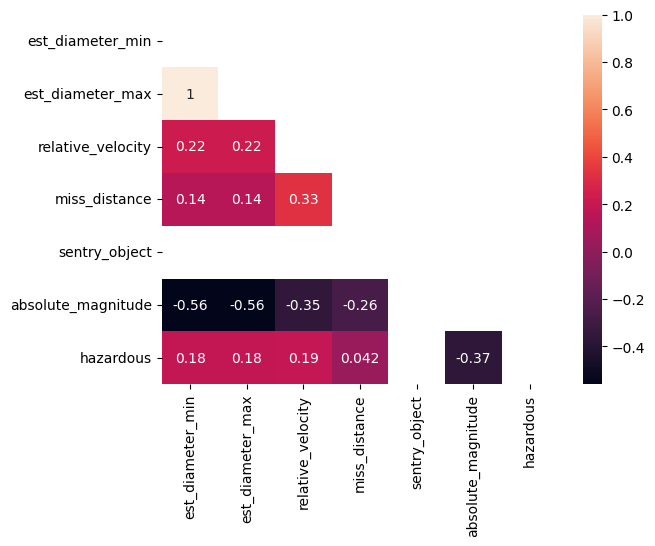

In [9]:
#Matriz de correlação para ver quais atributos tem maior correlação com o atributo de interesse
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,mask = mask ,annot=True)

In [10]:
#Mantendo variáveis que tem correlação maior que 0.1 com a variável de interesse
threshold = 0.1
columns_to_keep = correlation_matrix['hazardous'].abs() > threshold
columns_to_keep['hazardous'] = True
columns_to_keep = columns_to_keep[columns_to_keep].index
df = df[columns_to_keep]

In [11]:
df.columns

Index(['est_diameter_min', 'est_diameter_max', 'relative_velocity',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

In [12]:
#A coluna de estimativa de tamanho mínimo vai ser removida, uma vez que já temos o tamanho máximo
df = df.drop(["est_diameter_min"],axis=1)

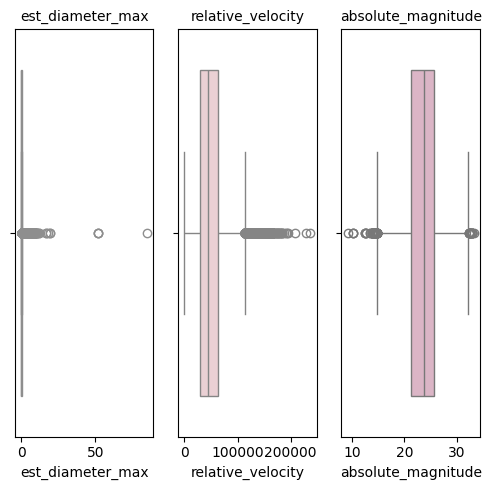

In [13]:
#Procurando por outliers
numerical = df.select_dtypes(include=['int', 'float']).copy()
rows, cols = 1,3
cube_palette = sns.cubehelix_palette(gamma=.5)

fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
axes = axes.flatten()

for i, col in enumerate(numerical.columns):
    if i < len(axes):
        sns.boxplot(x=df[col], ax=axes[i], color=cube_palette[i % len(cube_palette)])
        axes[i].set_title(col, fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
# Como pôde ser visto no output da célula anterior, temos outliers nas colunas 'est_diameter_max', 'relative_velocity' e 'absolute_magnitude'
# Os valores serão ajustados para os limites superiores e inferiores dos quartis na função abaixo
def handle_outliers(df, columns):
    
    """ Remove outliers do dataframe """

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

columns_to_handle= ['est_diameter_max','relative_velocity']
df = handle_outliers(df, columns_to_handle)

### Modelagem

#### Treino e validação do modelo

In [15]:
# Separando o dataset em treino e teste
target = df.hazardous.astype(int)

test_size = 0.20
seed = 10

X = df.drop("hazardous",axis=1)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y)


scoring = "recall"
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

A métrica utilizada será o recall, uma vez que o custo para um falso negativo nesse modelo é bastante elevado (um asteróide pode cair) e como vimos antes, as classes do atributo alvo estão desbalanceadas.

In [16]:
def evaluate(to_eval, X_train, y_train, kfold, scoring):
    """
    Função para avaliar modelos de machine learning

    Parâmetros:
        to_eval: lista de tuplas contendo o nome do modelo e o modelo ou pipeline a ser avaliado
        X_train: features de treino
        y_train: target de treino
        kfold: objeto de validação cruzada
        scoring: métrica de avaliação
    """
    results = []
    names = []
    for name, model_or_pipeline in to_eval:
        cv_results = cross_val_score(model_or_pipeline, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return results, names

def create_pipelines(models, scalers, dataset_types):
    """
    Cria pipelines para rodar modelos com diferentes tipos de datasets

    Parâmetros:
        models: lista de tuplas contendo o nome do modelo e o modelo
        scalers: lista de tuplas contendo o nome do scaler e o scaler
        dataset_types: lista contendo os tipos de dataset a serem avaliados
    """
    pipelines = []
    for dataset_type in dataset_types:
        if dataset_type == 'original':
            # Dados originais (sem scaler)
            pipelines.extend([(f'{model[0]}-orig', Pipeline([model])) for model in models])

        elif dataset_type == 'padronizado':
            # Dados padronizados
            pipelines.extend([(f'{model[0]}-padr', Pipeline([scalers[0], model])) for model in models])
        
        elif dataset_type == 'normalizado':
            # Dados normalizados
            pipelines.extend([(f'{model[0]}-norm', Pipeline([scalers[1], model])) for model in models])
    return pipelines

KNN-orig: 0.062643 (0.006436)
CART-orig: 0.424074 (0.017823)
NB-orig: 0.188915 (0.010845)
SVM-orig: 0.000000 (0.000000)
KNN-padr: 0.254953 (0.013209)
CART-padr: 0.424781 (0.017586)
NB-padr: 0.527289 (0.015984)
SVM-padr: 0.000000 (0.000000)
KNN-norm: 0.262870 (0.013874)
CART-norm: 0.424074 (0.017924)
NB-norm: 0.527289 (0.015984)
SVM-norm: 0.000000 (0.000000)


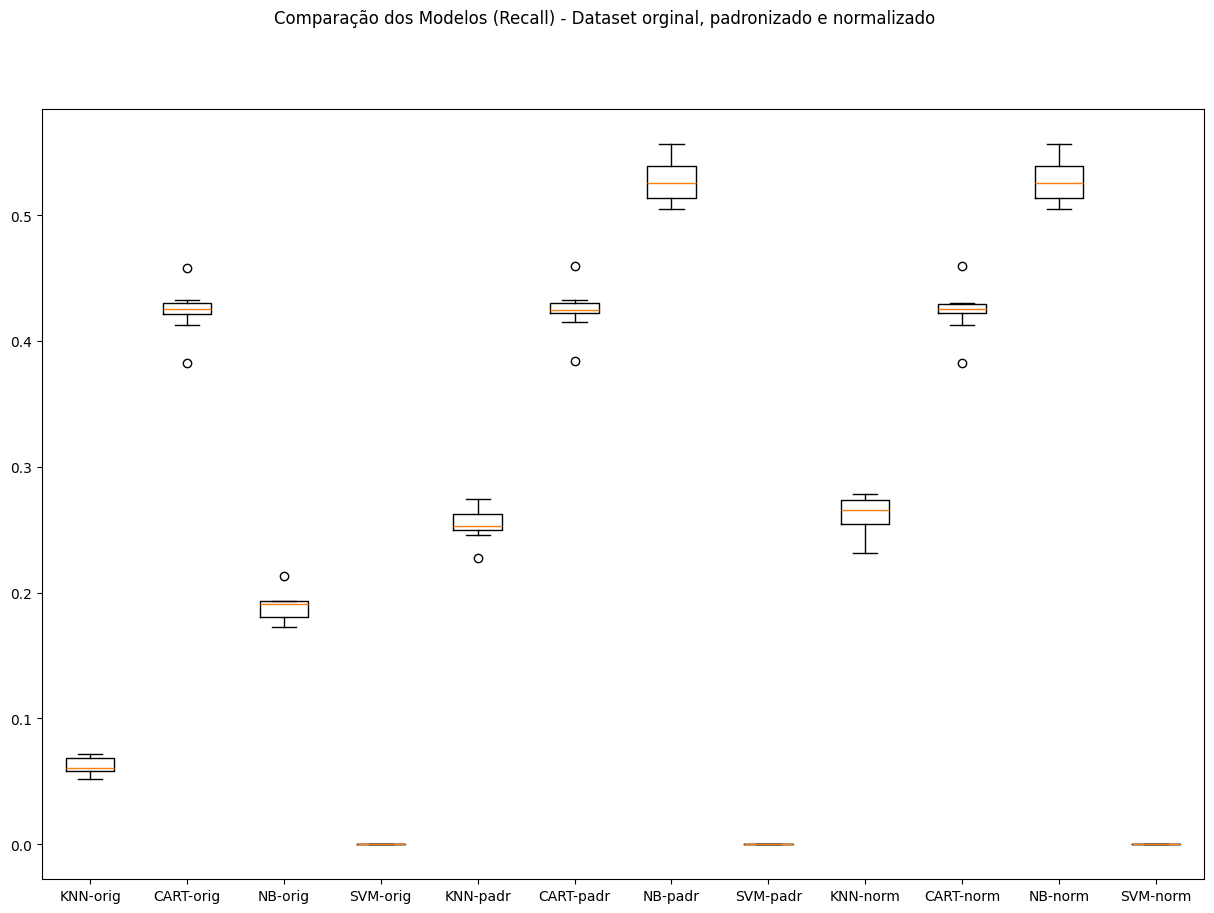

In [18]:
np.random.seed(10)

#definindo os tipos de modelos que serão avaliados e criando uma lista com eles

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

models = [knn, cart, naive_bayes, svm]

#Steps para o pipeline usando dados padronizados e normalizados
standard_scaler = ('StandardScaler', StandardScaler()) 
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

scalers = [standard_scaler, min_max_scaler]

#Tipos de datasets que serão avaliados
dataset_types = ['original', 'padronizado', 'normalizado']

#Cria um pipeline para cada modelo e tipo de dataset
pipelines = create_pipelines(models, scalers, dataset_types)
results, names = evaluate(pipelines, X_train, y_train, kfold, scoring)

fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos (Recall) - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

O modelo SVM teve um péssimo desempenho, claramente não conseguiu lidar com o desbalanceamento das classes sem um tratamento adicional como oversampling ou undersampling. Por conta disso, será retirado da fase de otimização de hiper parâmetros.

Modelagem: Otimização de Hiper parâmetros

In [19]:
#Definição dos parâmetros para o GridSearch
param_grids = {
            'KNN': {
                'KNN__n_neighbors': [3, 5, 7, 9, 11],
                'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
                'KNN__weights': ['uniform', 'distance']

            },
            'CART': {
                'CART__criterion': ['gini', 'entropy'],
                'CART__max_depth': [None, 10, 20, 30],
                'CART__min_samples_split': [2, 5, 10],
                'CART__min_samples_leaf': [1, 2, 4]
            },
            'NB': {
                'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
            }
        }

#Retirando os modelos SVM do GridSearch
pipelines_to_eval = [(name, model) for name, model in pipelines if 'SVM-' not in name]
for name, model in pipelines_to_eval:
    model_name = name.split('-')[0]
    gs = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=kfold, scoring=scoring)
    gs.fit(X_train, y_train)
    print(f'Melhor parâmetro para o modelo {name}: {gs.best_params_} com recall de {gs.best_score_}')

Melhor parâmetro para o modelo KNN-orig: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'} com recall de 0.21620717761848823
Melhor parâmetro para o modelo CART-orig: {'CART__criterion': 'gini', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2} com recall de 0.4256293002181574
Melhor parâmetro para o modelo NB-orig: {'NB__var_smoothing': 1e-09} com recall de 0.18891492660161896
Melhor parâmetro para o modelo KNN-padr: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'} com recall de 0.359028560241012
Melhor parâmetro para o modelo CART-padr: {'CART__criterion': 'gini', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2} com recall de 0.4236495017540495
Melhor parâmetro para o modelo NB-padr: {'NB__var_smoothing': 1e-09} com recall de 0.5272888547934695
Melhor parâmetro para o modelo KNN-norm: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3, 'KNN__weights': 'dis

Após os ajustes nos hiper parâmetros, o modelo de Naive Bayes foi o escolhido, com os dados padronizados e o hiperparametro var_smoothing: 1e-09

#### Escolha final do modelo e avaliação com conjunto de teste

In [20]:
np.random.seed(10)

scaler = StandardScaler()

model = GaussianNB(var_smoothing=1e-9)
pipeline = Pipeline([('StandardScaler', scaler), ('NB', model)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('StandardScaler', StandardScaler()), ('NB', GaussianNB())])

In [21]:
predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
test_recall = recall_score(y_test, predictions)
print(f"Acurácia com dados de teste: {test_accuracy}")
print(f"Recall com dados de teste: {test_recall}")

Acurácia com dados de teste: 0.8268934390136504
Recall com dados de teste: 0.5243212669683258


O modelo manteve um ótimo desempenho com o conjunto de teste, mostrando que tem boa capacidade de generalização, boa acurácia e um bom recall.

In [22]:
#Preparando o modelo com todo o dataset
pipeline.fit(X,y)

Pipeline(steps=[('StandardScaler', StandardScaler()), ('NB', GaussianNB())])

In [25]:
#Testando o modelo com dados fictícios

#Criando um dicionário com os dados fictícios
data = {'est_diameter_max': [0.569349,0.128000,1.028502,0.428000,0.589000],
        'relative_velocity': [1223.503675, 452467.865534, 410438.480615, 432.24324, 6792430.697200],
        'absolute_magnitude': [22.1, 21.1, 20.1, 19.1, 18.1]}


#Criando um dataframe com os dados fictícios
df_testes = pd.DataFrame(data)

array_input = df_testes.values
rescaled_input = scaler.transform(array_input)

predictions_test = model.predict(rescaled_input)
print(predictions_test)


[0 1 1 0 1]


O resultado com dados fictícios faz sentido, já que ele classificou os asteróides maiores e mais rápidos como perigosos.

In [28]:
#Salvando o pipeline do modelo
model_path = 'pipeline.pkl'
with open(model_path, 'wb') as file:
    dump(pipeline, file)

## Conclusão

- Embora eu acredite que o modelo não tenha aplicabilidade real, escolhi esse dataset mais pra tentar me divertir com os dados e explorar possibilidades diferentes de classificação, além das já muito conhecidas aplicabilidades nas áreas da saúde, análise de sentimento, mercado financeiro e cyber segurança com modelos de classificação de spam, anti fraudes e muitos outros.
- Acredito que a escolha do recall como métrica de avaliação foi a mais acertada, uma vez que o desbalanceamento dos dados poderia levar a classificações erradas mesmo tendo um modelo com alta acurácia. 
- Os dados claramente tem uma correlação forte e lógica entre o tamanho do asteróide e sua velocidade de deslocamento com a possibilidade dele cair na Terra e causar um estrago. 
- O modelo certamente se beneficiaria do uso de técnicas de balanceamento dos dados, para evitar equívocos em modelos com alta acurácia e muitos falsos negativos.